# Dogs vs Cats Redux

In [183]:
%matplotlib inline

This competition is centered around distinguishing images of dogs and cats. More details are available at [Dogs vs Cats Redux Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition).

**Action Plan**
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories
3. Create Model
4. Finetune and Train model
5. Generate predictions
6. Validate predictions
7. Submit predictions to Kaggle

Before we start sure you are running this notebook on the correct directory.

In [1]:
%pwd

u'/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs'

You should launch your notebook from inside `lessons/01-recognizing-cats-and-dogs` directory:

```
$ cd lessons/01-recognizing-cats-and-dogs
$ jupyter notebook
```

## 1. Create Validation and Sample Sets

### 1.1. Create directory references

In [2]:
import os
LESSON_HOME_DIR = os.getcwd()
DATA_HOME_DIR = LESSON_HOME_DIR + '/data/dogs-vs-cats-redux'

### 1.2. Create directories

In [5]:
%mkdir -p $DATA_HOME_DIR

%cd $DATA_HOME_DIR

%mkdir results
%mkdir -p sample/results
%mkdir -p sample/test
%mkdir -p sample/train
%mkdir -p sample/valid
%mkdir test
%mkdir valid

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux


### 1.3. Download data from Kaggle

At the end of this step, we should have a directory structure that looks similar to:

```
lesson1/
    dogs-vs-cats-redux.ipynb
    data/
        dogs-vs-cats/
            train/
                cat.1.jpg
                dog.10.jpg
                cat.11.jpg
                dog.12.jpg
            test/
                1.jpg
                10.jpg
                11.jpg
                12.jpg
```

#### 1.3.1. Install and configure kaggle-cli

We will be using a command-line utility that helps us downloading data and submitting our results to Kaggle. Please install [kaggle-cli](https://github.com/floydwch/kaggle-cli) on your machine using:

```
$ pip install kaggle-cli
```

Once installed, go to the directory where you are running this notebook and execute:

```
$ kg config -u <YOUR_KAGGLE_USER> -p <YOUR_KAGGLE_PASSWORD> -c dogs-vs-cats-redux-kernels-edition
```

**This will save your credentials locally in plain text. Be careful to not commit them to your repository!**

Once configure, go ahead and download the challenge data:

In [4]:
!kg download

Starting new HTTPS connection (1): www.kaggle.com
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip
Starting new HTTPS connection (1): kaggle2.blob.core.windows.net
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv


### 1.4. Extract data

Once downloaded, extract the zip files inside the data directory

In [8]:
%cd $LESSON_HOME_DIR

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs


In [252]:
!unzip test.zip -d data/dogs-vs-cats-redux/ >nul 2>&1

In [255]:
!unzip train.zip -d data/dogs-vs-cats-redux/ >nul 2>&1

### 1.5. Create Validation Set

In [20]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/train


In [15]:
from glob import glob
import numpy as np

images = glob('*.jpg')
shuffle = np.random.permutation(images)

for i in range(2000):
    os.rename(shuffle[i], DATA_HOME_DIR + '/valid/' + shuffle[i])

In [22]:
from shutil import copyfile

images = glob('*.jpg')
shuffle = np.random.permutation(images)

for i in range(200):
    copyfile(shuffle[i], DATA_HOME_DIR + '/sample/valid/' + shuffle[i])

### 1.6. Create Training Set

In [17]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/train


In [18]:
from shutil import copyfile

images = glob('*.jpg')
shuffle = np.random.permutation(images)

for i in range(200):
    copyfile(shuffle[i], DATA_HOME_DIR + '/sample/train/' + shuffle[i])

## 2. Rearrange image files into their respective directories

### 2.1. Rearrange Validation Set

In [26]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/valid


In [30]:
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [31]:
%cd $DATA_HOME_DIR/sample/valid

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/sample/valid


In [32]:
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

### 2.2. Rearrange Train Set

In [33]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/train


In [34]:
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [35]:
%cd $DATA_HOME_DIR/sample/train

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/sample/train


In [36]:
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

### 2.3. Rearrange Test Set

In [37]:
%cd $DATA_HOME_DIR/test

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux/test


In [39]:
%mkdir unknown
%mv *.jpg unknown/

## 3. Create Model

Basic dependencies

In [82]:
import json

Numpy dependencies

In [83]:
import numpy as np
from numpy.random import random
from numpy.random import permutation

np.set_printoptions(precision=4, linewidth=100)

Scipy dependencies

In [84]:
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

Keras dependencies

In [85]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.preprocessing import image

We need to create the model architecture, and then load the model weights into that architecture.
In here we will duplicate the same architecture as VGG16.

In [114]:
class VGG16:
    def __init__(self):
        # When the VGG model was trained in 2014, the creators subtracted the
        # average of each of the three (R,G,B) channels first, so that the data
        # for each channel had a mean of zero.
        # Furthermore, their software that expected the channels to be in B,G,R order,
        # whereas Python by default uses R,G,B. We need to preprocess our data to
        # make these two changes, so that it is compatible with the VGG model:
        def vgg_preprocess(x):
            vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
            x = x - vgg_mean
            # reverse axis bgr->rgb
            return x[:, ::-1]

        self.model = Sequential()
        self.model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))
        
        self._add_convolutional_block(2, 64)
        self._add_convolutional_block(2, 128)
        self._add_convolutional_block(3, 256)
        self._add_convolutional_block(3, 512)
        self._add_convolutional_block(3, 512)

        self.model.add(Flatten())

        self._add_fully_connected_block()
        self._add_fully_connected_block()

        self.model.add(Dense(1000, activation='softmax'))
    
    def _add_convolutional_block(self, layers, filters):
        for i in range(layers):
            self.model.add(ZeroPadding2D((1,1)))
            self.model.add(Convolution2D(filters, 3, 3, activation='relu'))
        self.model.add(MaxPooling2D((2,2), strides=(2,2)))

    def _add_fully_connected_block(self):
        self.model.add(Dense(4096, activation='relu'))
        self.model.add(Dropout(0.5))
        
    def get_batches(self,
                    directory,
                    gen=image.ImageDataGenerator(),
                    shuffle=True,
                    batch_size=8,
                    class_mode='categorical'):
        return gen.flow_from_directory(directory,
                                       target_size=(224, 224),
                                       shuffle=shuffle,
                                       batch_size=batch_size,
                                       class_mode=class_mode)
    
    def finetune(self, training_batches):
        self.model.pop()
        
        for layer in self.model.layers:
            layer.trainable = False
        
        self.model.add(Dense(training_batches.nb_class, activation='softmax'))
        self.model.compile(optimizer=RMSprop(lr=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        
    def fit(self, training_batches, validation_batches, nb_epoch=1):
        self.model.fit_generator(training_batches,
                            samples_per_epoch=training_batches.nb_sample,
                            nb_epoch=nb_epoch,
                            validation_data=validation_batches,
                            nb_val_samples=validation_batches.nb_sample)
        
    def test(self, test_batches):
        predictions = self.model.predict_generator(test_batches,
                                                   test_batches.nb_sample)
        return test_batches.filenames, predictions

What we know right now:
- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

## 4. Finetune and Training

Now we are ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [106]:
vgg = VGG16()

We need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem.

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [100]:
PRE_TRAINED_WEIGHTS_FILE = 'vgg16.h5'
pre_trained_weights = get_file(PRE_TRAINED_WEIGHTS_FILE,
                               'http://www.platform.ai/models/' + PRE_TRAINED_WEIGHTS_FILE,
                               cache_subdir='models')

Then we load the weights into our model.

In [107]:
vgg.model.load_weights(pre_trained_weights)

In [95]:
RESULTS_PATH = DATA_HOME_DIR + '/results/'
TEST_PATH = DATA_HOME_DIR + '/test/'
TRAIN_PATH = DATA_HOME_DIR + '/train/'
VALID_PATH = DATA_HOME_DIR + '/valid/'

BATCH_SIZE = 64
EPOCHS = 5

In [108]:
training_batches = vgg.get_batches(TRAIN_PATH, batch_size=BATCH_SIZE)
validation_batches = vgg.get_batches(VALID_PATH, batch_size=BATCH_SIZE)
vgg.finetune(training_batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [109]:
latest_weight_filename = None
for epoch in range(EPOCHS):
    print "Running epoch: %d" % epoch
    vgg.fit(training_batches, validation_batches)
    latest_weight_filename = "dogs-vs-cats-fit-%d.h5" % epoch
    vgg.model.save_weights(RESULTS_PATH + latest_weight_filename)
    
print "Completed %d fit operations" % EPOCHS

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 640s - loss: 0.1180 - acc: 0.9696 - val_loss: 0.0586 - val_acc: 0.9825
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 636s - loss: 0.0993 - acc: 0.9780 - val_loss: 0.0502 - val_acc: 0.9875
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 636s - loss: 0.1035 - acc: 0.9779 - val_loss: 0.0639 - val_acc: 0.9865
Running epoch: 3
Epoch 1/1
23000/23000 [==============================] - 636s - loss: 0.0958 - acc: 0.9793 - val_loss: 0.0594 - val_acc: 0.9870
Running epoch: 4
Epoch 1/1
23000/23000 [==============================] - 636s - loss: 0.1047 - acc: 0.9793 - val_loss: 0.0744 - val_acc: 0.9865
Completed 5 fit operations


## 5. Generate Predictions

In [220]:
vgg = VGG16()
vgg.model.load_weights(RESULTS_PATH + 'dogs-vs-cats-fit-4.h5')

In [221]:
test_batches = vgg.get_batches(TEST_PATH,
                               shuffle=False,
                               batch_size=BATCH_SIZE,
                               class_mode=None)
filenames, predictions = vgg.test(test_batches)

Found 12500 images belonging to 1 classes.


In [222]:
import bcolz

f = bcolz.carray(filenames, rootdir=RESULTS_PATH + 'filenames.dat', mode='w')
f.flush()

p = bcolz.carray(predictions, rootdir=RESULTS_PATH + 'predictions.dat', mode='w')
p.flush()

## 6. Validate Predictions

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [223]:
vgg = VGG16()
vgg.model.load_weights(RESULTS_PATH + 'dogs-vs-cats-fit-4.h5')

In [224]:
validation_batches = vgg.get_batches(VALID_PATH,
                                     shuffle=False,
                                     batch_size=BATCH_SIZE,
                                     class_mode=None)
filenames, predictions = vgg.test(validation_batches)

Found 2000 images belonging to 2 classes.


In [225]:
expected_labels = validation_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
actual_predictions = predictions[:,0]
actual_labels = np.round(1-our_predictions)

In [197]:
from matplotlib import pyplot as plt
import itertools
from itertools import chain
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(VALID_PATH + filenames[i]) for i in idx], titles=titles)
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')    

Found 1973 correct labels


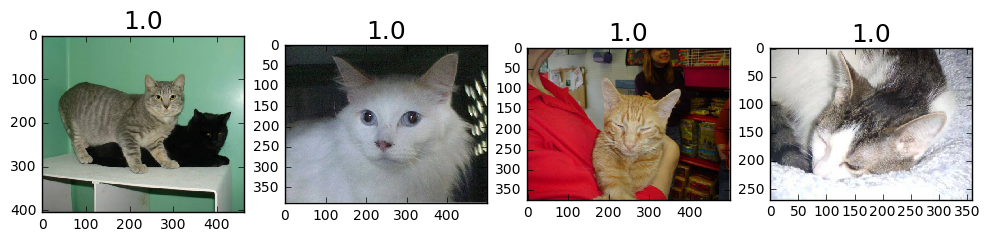

In [226]:
#1. Correct labels
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)

idx = permutation(correct)[:4]
plots_idx(idx, our_predictions[idx])

Found 27 incorrect labels


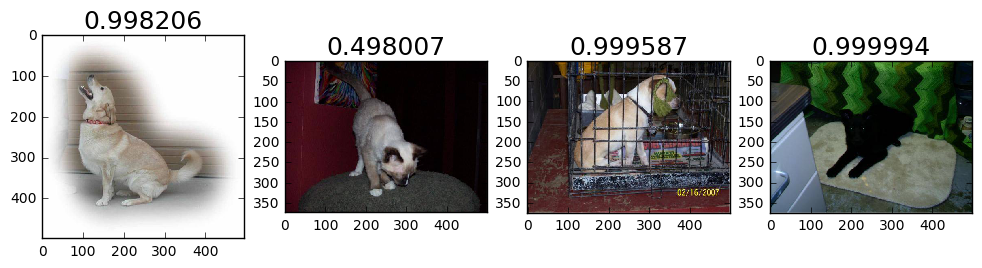

In [227]:
#2. Incorrect labels
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)

idx = permutation(incorrect)[:4]
plots_idx(idx, our_predictions[idx])

Found 993 confident correct cats labels


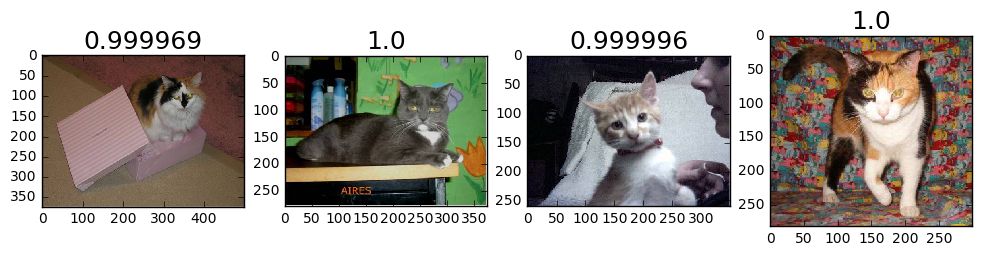

In [228]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((actual_labels==0) & (actual_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)

idx = permutation(correct_cats)[:4]
plots_idx(idx, our_predictions[idx])

Found 993 confident correct dogs labels


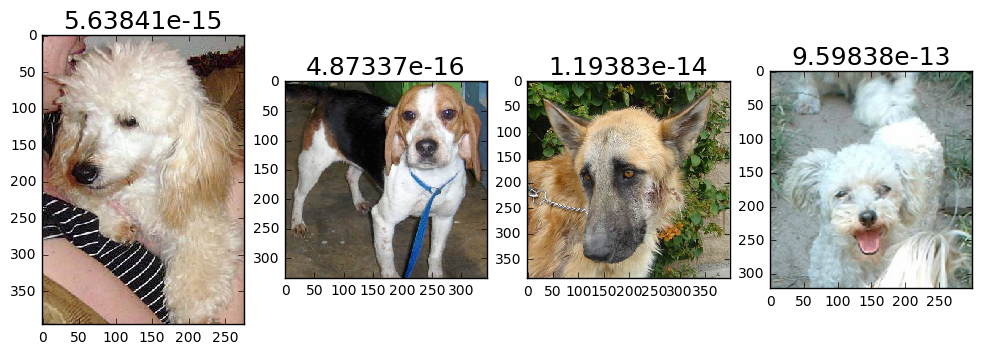

In [229]:
#4. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((actual_labels==1) & (actual_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_cats)

idx = permutation(correct_dogs)[:4]
plots_idx(idx, our_predictions[idx])

Found 11 incorrect cats


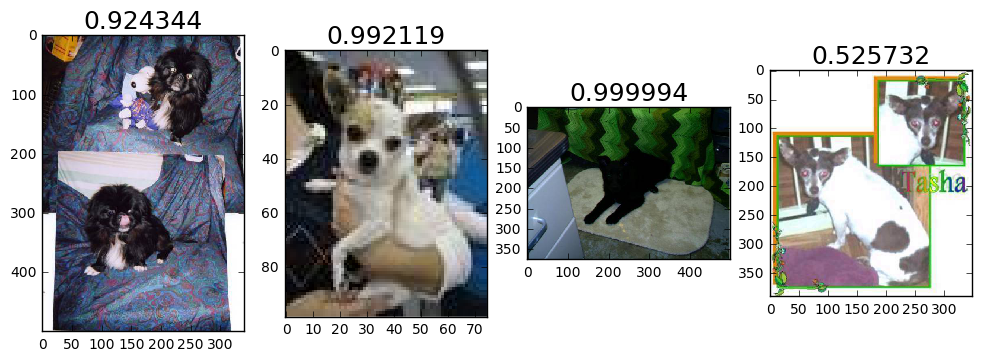

In [230]:
#5. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)

idx = permutation(incorrect_cats)[:4]
plots_idx(idx, our_predictions[idx])

Found 16 incorrect dogs


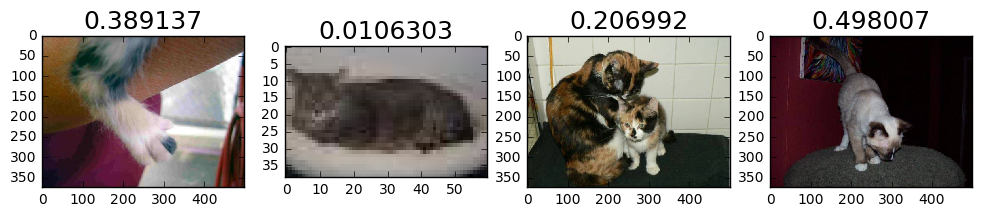

In [231]:
#6. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)

idx = permutation(incorrect_dogs)[:4]
plots_idx(idx, our_predictions[idx])

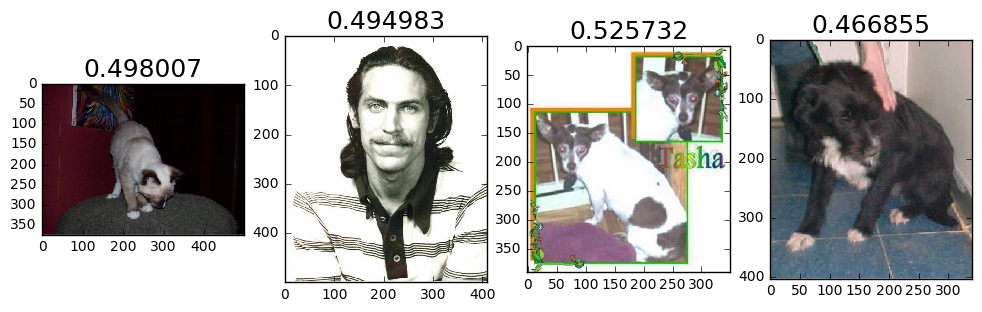

In [232]:
#7. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [194]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[993  16]
 [ 11 980]]


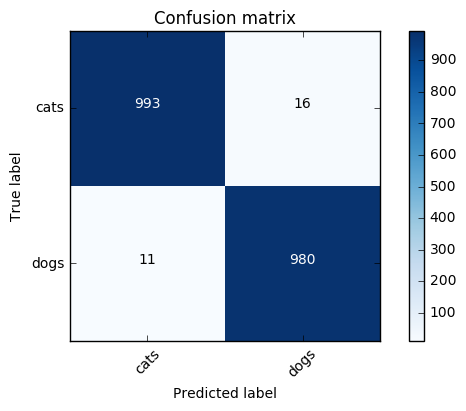

In [234]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, validation_batches.class_indices)

## 7. Submit Predictions to Kaggle

In [235]:
predictions = bcolz.open(RESULTS_PATH + 'predictions.dat')[:]
filenames = bcolz.open(RESULTS_PATH + 'filenames.dat')[:]

In [256]:
isdog = predictions[:,1]
#To play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .99 and all zeros with .01
isdog = isdog.clip(min=0.001, max=0.999)

In [257]:
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [258]:
submission = np.stack([ids, isdog], axis=1)
submission[:5]

array([[  1.0000e+00,   9.9900e-01],
       [  1.0000e+01,   1.0000e-03],
       [  1.0000e+02,   1.0000e-03],
       [  1.0000e+03,   9.9900e-01],
       [  1.0000e+04,   9.9900e-01]])

In [261]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission5.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/practical-deep-learning-for-coders/lessons/01-recognizing-cats-and-dogs/data/dogs-vs-cats-redux


In [262]:
!kg submit submission5.csv

Starting new HTTPS connection (1): www.kaggle.com
'NoneType' object has no attribute 'find'
